In [1]:
import random
import io
import pickle

import numpy as np
import pandas as pd

!pip install tensorflow
!pip install keras 

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout, Bidirectional, SpatialDropout1D

In [2]:
import os
import gdown
if os.access('movie_lines.tsv', os.F_OK) is False:
    url = 'https://drive.google.com/file/d/16SuG97IRY1B8zXlE61skME0OgdlZdS6-/view?usp=sharing'
    output = 'movie_lines.tsv'
    gdown.download(url, output, quiet=False)
else:
    print("El dataset ya se encuentra descargado")

El dataset ya se encuentra descargado


### Dataset
##### El dataset contiene diálogos completos de películas. Vamos a filtrar el de la película Gladiador y vamos a ver si se puede predecir la línea del héroe protagonista cuando el emperador le exige que revele su nombre en la arena del Coliseo. Para más referencias sobre el dataset ver acá [Movie Dialog Corpus](https://www.kaggle.com/Cornell-University/movie-dialog-corpus)

In [3]:
dataset = pd.read_csv(
    "movie_lines.tsv", 
    sep='\t', 
    encoding='utf-8',
    names = ['lineID', 'characterID ', 'movieID', 'character', 'line']
)

In [4]:
dataset

,lineID,characterID,movieID,character,line
0,L1045,u0,m0,BIANCA,They do not!
1,L1044,u2,m0,CAMERON,They do to!
2,L985,u0,m0,BIANCA,I hope so.
3,L984,u2,m0,CAMERON,She okay?
4,L925,u0,m0,BIANCA,Let's go.
...,...,...,...,...,...
293363,L666371,u9030,m616,DURNFORD,Lord Chelmsford seems to want me to stay back ...
293364,L666370,u9034,m616,VEREKER,I'm to take the Sikali with the main column to...
293365,L666369,u9030,m616,DURNFORD,Your orders Mr Vereker?
293366,L666257,u9030,m616,DURNFORD,Good ones yes Mr Vereker. Gentlemen who can ri...


In [5]:
peli = dataset.loc[dataset['movieID'] == 'm76']

In [6]:
print("Cantidad de lineas de dialogo:", peli.shape[0])

Cantidad de lineas de dialogo: 370


In [7]:
peli.head()

,lineID,characterID,movieID,character,line
36721,L243076,u1155,m76,COMMODUS,What have I got now? It's exactly as if there...
36722,L243075,u1161,m76,LUCILLA,You would have had a full scale revolt on your...
36723,L243074,u1155,m76,COMMODUS,Damn him! I should have killed him on the fro...
36724,L243028,u1161,m76,LUCILLA,Do you want posters too?
36725,L243027,u1155,m76,COMMODUS,Lykas pick a man. Someone who will look good....


In [8]:
lines = peli['line']

### Corpus

In [9]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.text import text_to_word_sequence 
from keras.preprocessing.sequence import pad_sequences

In [10]:
corpus = ' '.join(lines)
corpus

"What have I got now?  It's exactly as if there were two emperors. Because of this the people have two minds.  He is their champion. You would have had a full scale revolt on your hands. Damn him!  I should have killed him on the front -- I let you talk me out of that. Do you want posters too? Lykas pick a man.  Someone who will look good.  Jerses I want it built up in the Daily Action... Send them out! Not yet dear brother... I am their hero! You want control of the crowd -- you can't get it by killing their hero. I want that bastard dead! You can't do that... listen to the mood of the crowd. Tell Lykas to send a retiarius and a Samnite to help Tiger. Yes?  Go on! But I get what I want always don't I? If I ever loved Narcissus it wasn't like you want. Now that we're done with that infatuation forever. What are you talking about? Now that is a happy sound! Tomorrow I want the citizens -- my people -- back in the arena.  The Gods know I'm tired.  Come to bed now; tonight we're celebrati

In [11]:
tokens = text_to_word_sequence(corpus)
tokens[:20]

['what',
 'have',
 'i',
 'got',
 'now',
 "it's",
 'exactly',
 'as',
 'if',
 'there',
 'were',
 'two',
 'emperors',
 'because',
 'of',
 'this',
 'the',
 'people',
 'have',
 'two']

In [12]:
print("Cantidad de tokens en el corpus:", len(tokens))

Cantidad de tokens en el corpus: 5731


In [13]:
train_len = 5

In [14]:
text_sequences = []
for i in range(train_len, len(tokens)):
  seq = tokens[i-train_len:i]
  text_sequences.append(seq)

In [15]:
text_sequences[:5]

[['what', 'have', 'i', 'got', 'now'],
 ['have', 'i', 'got', 'now', "it's"],
 ['i', 'got', 'now', "it's", 'exactly'],
 ['got', 'now', "it's", 'exactly', 'as'],
 ['now', "it's", 'exactly', 'as', 'if']]

In [16]:
tok = Tokenizer() 
tok.fit_on_texts(text_sequences) 

sequences = tok.texts_to_sequences(text_sequences)

sequences[:20]

[[18, 13, 4, 180, 53],
 [13, 4, 180, 53, 34],
 [4, 180, 53, 34, 217],
 [180, 53, 34, 217, 42],
 [53, 34, 217, 42, 31],
 [34, 217, 42, 31, 76],
 [217, 42, 31, 76, 93],
 [42, 31, 76, 93, 181],
 [31, 76, 93, 181, 569],
 [76, 93, 181, 569, 120],
 [93, 181, 569, 120, 6],
 [181, 569, 120, 6, 21],
 [569, 120, 6, 21, 1],
 [120, 6, 21, 1, 67],
 [6, 21, 1, 67, 13],
 [21, 1, 67, 13, 181],
 [1, 67, 13, 181, 570],
 [67, 13, 181, 570, 24],
 [13, 181, 570, 24, 8],
 [181, 570, 24, 8, 77]]

In [17]:
print("Cantidad de rows del dataset:", len(sequences))

Cantidad de rows del dataset: 5726


### Set de entrenamiento

In [18]:
arr_sequences = np.array(sequences)
x_data = arr_sequences[:,:-1]
y_data_int = arr_sequences[:,-1]

print(x_data.shape)
print(y_data_int.shape)

(5726, 4)
(5726,)


In [19]:
x_data

array([[  18,   13,    4,  180],
       [  13,    4,  180,   53],
       [   4,  180,   53,   34],
       ...,
       [   2, 1264,   69,   66],
       [1264,   69,   66,   18],
       [  69,   66,   18,   41]])

In [20]:
tok.index_word

{1: 'the',
 2: 'you',
 3: 'to',
 4: 'i',
 5: 'a',
 6: 'of',
 7: 'and',
 8: 'is',
 9: 'that',
 10: 'your',
 11: 'be',
 12: 'in',
 13: 'have',
 14: 'my',
 15: 'for',
 16: 'it',
 17: 'me',
 18: 'what',
 19: 'will',
 20: 'do',
 21: 'this',
 22: 'are',
 23: 'want',
 24: 'he',
 25: 'on',
 26: 'with',
 27: 'know',
 28: "i'm",
 29: 'we',
 30: 'they',
 31: 'if',
 32: 'but',
 33: 'get',
 34: "it's",
 35: 'who',
 36: "don't",
 37: 'rome',
 38: 'them',
 39: 'at',
 40: 'about',
 41: 'was',
 42: 'as',
 43: 'not',
 44: 'can',
 45: 'all',
 46: 'an',
 47: 'so',
 48: 'our',
 49: 'would',
 50: 'out',
 51: 'narcissus',
 52: 'caesar',
 53: 'now',
 54: 'man',
 55: "you're",
 56: 'senate',
 57: 'him',
 58: "he's",
 59: 'think',
 60: 'commodus',
 61: 'has',
 62: 'emperor',
 63: 'then',
 64: 'going',
 65: 'army',
 66: 'one',
 67: 'people',
 68: 'tell',
 69: 'like',
 70: 'why',
 71: 'back',
 72: 'his',
 73: 'how',
 74: 'us',
 75: 'take',
 76: 'there',
 77: 'their',
 78: 'good',
 79: 'make',
 80: 'right',
 81: '

In [21]:
vocab_size = len(tok.word_counts)
vocab_size

1264

In [22]:
y_data = to_categorical(y_data_int, num_classes=y_data_int.shape[0])

In [23]:
y_data_int_offset = y_data_int - 1
y_data = to_categorical(y_data_int_offset, num_classes=vocab_size) 
y_data.shape

(5726, 1264)

In [24]:
input_seq_len = x_data.shape[1] 
input_seq_len

4

In [27]:
model = Sequential()

model.add(Embedding(input_dim=vocab_size+1, output_dim=32, input_length=input_seq_len))
model.add(SpatialDropout1D(0.4))
model.add(Bidirectional(LSTM(128, dropout=0.05, recurrent_dropout=0.2)))
model.add(Dense(128, activation='relu'))
model.add(Dense(vocab_size, activation='softmax'))


model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 4, 32)             40480     
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 4, 32)             0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               164864    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 1264)              163056    
Total params: 401,296
Trainable params: 401,296
Non-trainable params: 0
_________________________________________________________________


In [28]:
hist = model.fit(x_data, y_data, epochs=100, validation_split=0.2)

Epoch 1/100
144/144 [==============================] - 10s 34ms/step - loss: 6.4134 - accuracy: 0.0496 - val_loss: 6.2653 - val_accuracy: 0.0366
Epoch 2/100
144/144 [==============================] - 4s 29ms/step - loss: 5.8858 - accuracy: 0.0552 - val_loss: 6.2745 - val_accuracy: 0.0366
Epoch 3/100
144/144 [==============================] - 4s 30ms/step - loss: 5.7614 - accuracy: 0.0561 - val_loss: 6.3276 - val_accuracy: 0.0445
Epoch 4/100
144/144 [==============================] - 4s 29ms/step - loss: 5.6225 - accuracy: 0.0587 - val_loss: 6.3827 - val_accuracy: 0.0401
Epoch 5/100
144/144 [==============================] - 4s 29ms/step - loss: 5.5248 - accuracy: 0.0592 - val_loss: 6.5907 - val_accuracy: 0.0375
Epoch 6/100
144/144 [==============================] - 4s 30ms/step - loss: 5.4454 - accuracy: 0.0653 - val_loss: 6.6895 - val_accuracy: 0.0471
Epoch 7/100
144/144 [==============================] - 4s 29ms/step - loss: 5.3682 - accuracy: 0.0681 - val_loss: 6.9252 - val_accuracy

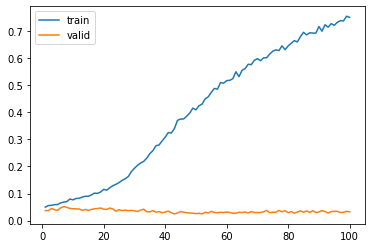

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.show()

In [30]:
def generate_seq(model, tokenizer, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            tokenizer (keras tokenizer): tonenizer utilizado en el preprocesamiento
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de palabras a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	# generate a fixed number of words
    for _ in range(n_words):
		# Encodeamos
        encoded = tokenizer.texts_to_sequences([output_text])[0]
		# Si tienen distinto largo
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')
		
		# Predicción softmax
        y_hat = model.predict(encoded).argmax(axis=-1)
		# Vamos concatenando las predicciones
        out_word = ''

        # Debemos buscar en el vocabulario la palabra
        # que corresopnde al indice (y_hat) predicho por le modelo
        for word, index in tokenizer.word_index.items():
            if index == y_hat:
                out_word = word
                break

		# Agrego las palabras a la frase predicha
        output_text += ' ' + out_word
    return output_text

In [32]:
input_text='my name is Maximus'

prediction = generate_seq(model, tok, input_text, max_length=3, n_words=2)

print(f'{input_text} --> {prediction}')

my name is Maximus --> my name is Maximus want at
